In [1]:
#!pip install pypinyin

In [2]:
from pathlib import Path
import json
import re
import re
from pypinyin import lazy_pinyin, Style
from difflib import SequenceMatcher
from functools import cache

In [3]:
data_dir = Path("../../data")
if not data_dir.exists():
    data_dir = Path("./")

### Metadata

In [4]:
meta_dir = data_dir / "metadata"
meta_dir = meta_dir if meta_dir.exists() else data_dir
metadatapath = Path(meta_dir).glob('*_metadata.json')
metadata = []
for file in metadatapath:
    data = json.load(file.open(encoding="UTF-8"))
    for dic in data:
        metadata.append(dic)
len(metadata)

142

### Asr data

In [5]:

asr_dir = data_dir / "asr"
asr_dir = asr_dir if asr_dir.exists() else data_dir
asr_data = {}
asrdatapath = Path(asr_dir).glob('*.gasr.json')
for file in asrdatapath:
    r = re.compile("(?<=-)[^.]+")
    i = r.findall(Path(file).name)
    videoid = i[0]
    asr_data[videoid]=json.load(file.open(encoding="UTF-8"))
len(asr_data)

119

### Ans data

In [6]:
ans_dir = data_dir / "manual-aligned"
ans_dir = ans_dir if ans_dir.exists() else data_dir
anspath = Path(ans_dir).glob('*.utterance.ans.txt')
ansdata = {}
for file in anspath:
    r = re.compile("(?<=-)[^.]+")
    i = r.findall(Path(file).name)
    videoid = i[0]
    ansdata[videoid] = file.read_text().split(",")

## 轉注音

In [7]:
tone_re = re.compile("[ˊˇˋ˙]")

@cache
def pinyin_cache(ch):
    return lazy_pinyin(ch, style=Style.BOPOMOFO)[0]

class CharPhone:
    def __init__(self, ch):
        assert len(ch)==1
        self.ch = ch
        self.zhuyin = pinyin_cache(ch)
        self.phones = tone_re.sub("", self.zhuyin)
    
    def __hash__(self):
        return hash(self.phones)
    
    def __eq__(self, other):        
        return self.phones == other.phones
    
    def __repr__(self):
        return f"<Char: {self.ch} ({self.zhuyin})>"        

def char_mapper(text):
    text = re.sub("[ \u3000，。：）（]", "", text)
    return [CharPhone(x) for x in text]

## Preprocess ASR

In [8]:
from itertools import chain

def to_num(x):
    return float(x.replace("s", ""))

def flatten_asr(asr_obj):    
    asr_starts = []
    asr_ends = []
    asr_words = []
    for entry_x in asr_obj:
        alts = entry_x.get("alternatives", [])
        if not alts: continue
        words = alts[0].get("words", [])        
        asr_starts.extend([
            to_num(x["startTime"]) for x in words])
        asr_ends.extend([
            to_num(x["endTime"]) for x in words])
        asr_words.extend([x["word"] for x in words])
        
    return {
        "starts": asr_starts,
        "ends": asr_ends,
        "words": asr_words
    }

## Preprocess 議事錄

In [9]:
import re
from itertools import tee
def preprocess_transcript(txt):
    txt = txt.replace("<br />", "")
    txt = re.sub("(\n\d+\n.+)", "", txt)
    txt = re.sub("（.+時.+分）", "", txt)
    txt = re.split("(\n?.+?：)(?=[^「])", txt)    
    txt = [x.replace("\n", "").strip() for x in txt]
    txt = [x for x in txt if x]
    txt = [re.split("，|。|？|！|；", x) for x in txt]

    y = []
    for x in txt:
        if re.search("(\n?.+?：)",x[0]):
            y.append(x[0])
        else:
            x_utter = [i for i in x if i]
            y.append(x_utter)

    iter_list = [iter(y)] * 2
    utterance = [(a,b) for a,b in zip(*iter_list)]
    try: utterance = [x for x in utterance if not re.search("主席：", x[0])]
    except: pass
    #utter = [x for x in utter if not x[0].startswith("主席：")]
    return utterance

In [10]:
#127873
txt = [x for x in metadata if x["video_id"]=="127873"][0]["transcript"]

txt = txt.replace("<br />", "")
txt = re.sub("(\n\d+\n.+)", "", txt)
txt = re.sub("（.+時.+分）", "", txt)
txt = re.split("(\n?.+?：)(?=[^「])", txt)
txt = [x.replace("\n", "").strip() for x in txt]
txt = [x for x in txt if x]
txt = [re.split("，|。|？|！|；", x) for x in txt]

y = []
for x in txt:
    if re.search("(\n?.+?：)", x[0]):
        y.append(x[0])
    else:
        x_utter = [i for i in x if i]
        y.append(x_utter)

iter_list = [iter(y)] * 2
utterance = [(a,b) for a,b in zip(*iter_list)]
try:     
    utterance = [x for x in utterance if not re.search("主席：", x[0])]
except: pass

In [11]:
utterance[3:7]

[('魯委員明哲：',
  ['我待會會把亂點跟你慢慢說',
   '我希望中央的客委會你們也要多用點心',
   '世博會我們補助 12 億',
   '占 15 億的 80%',
   '我們當然相信桃園市政府有這個能力',
   '因為過去也辦過一些大型活動',
   '如果你不要打「世界」',
   '就跟你沒有關係',
   '你打「世界客家博覽會」',
   '跟你的關係是非常大',
   '你想想看',
   '如果日本東奧辦不成、辦了很久',
   '是東京丟人、還是日本丟人多一點',
   '你自己去想這個問題……']),
 ('楊主任委員長鎮：', ['對', '當然是……']),
 ('魯委員明哲：',
  ['你不要打「世界博覽會」都沒問題喔',
   '所以我希望你跟桃園市政府',
   '就這件事情要多溝通',
   '那這個時間到底誰決定的',
   '那天我跟你聊了',
   '原本是說明年 7 月 15 日到 9 月 15 日',
   '最後的決定到底是什麼',
   '你們討論的過程',
   '原本是更晚一點',
   '後來又往前調整',
   '現在又整個往後延一年',
   '因為他們在市議會都說',
   '是中央決定的',
   '那中央決定的',
   '我就要注意一下',
   '是不是主委你決定的',
   '這是第一個問題']),
 ('楊主任委員長鎮：',
  ['就第一個問題',
   '剛剛提到的',
   '那之所以會往前',
   '就是因為那時候外界有質疑說',
   '跟選舉那麼靠近',
   '會不會被誤會跟選舉有關',
   '在臺灣我們常常都在選舉',
   '所以辦重大活動常常被附會到政治這個想像空間裡面',
   '這當然不是一個好的常態',
   '所以那時候我們認為說 OK 是不是可以再往前調',
   '所以就有這樣的聲音',
   '其實我們是考慮到客觀因素',
   '愈靠近選舉的時候',
   '整個議題都在選舉',
   '大家對於這個博覽會的注意可能會降低',
   '所以時候就往前調了'])]

## Ans metric

In [12]:
def compute_metric(aligned, ans, tol=3.):
    assert len(aligned) == len(ans)
    n_correct = 0

    for aligned_x, ans_x in zip(aligned, ans):
        t = datetime.strptime(ans_x,"%H:%M:%S")
        ansTD = timedelta(hours=t.hour, minutes=t.minute, seconds=t.second).total_seconds()
        alignTD = timedelta(seconds=aligned_x).total_seconds()

        error = abs(ansTD-alignTD)

        if error < tol:
            n_correct += 1
    metric = n_correct/len(aligned)
    return metric

## 注音對齊

In [13]:
import json
from datetime import datetime, timedelta
from difflib import SequenceMatcher
import numpy as np
import numpy.linalg as la
from scipy.stats import poisson, norm
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [14]:

def zhuyin_matching(key, wlambda=3, offset=0, win=10, use_weight=True, debug=False):
    asr = asr_data[key]["response"]["results"]
    transcript = [x for x in metadata if x["video_id"]==key][0]["transcript"]
    mdspeaker = [x for x in metadata if x["video_id"]==key][0]["speaker"]    
    ans = ansdata[key]   # for debug
    
    flat_asr = flatten_asr(asr)
    assert len(flat_asr["starts"]) == len(flat_asr["words"])

    turns = preprocess_transcript(transcript)
    
    asr_words = flat_asr["words"] 
    asr_starts = flat_asr["starts"]
    asr_ends = flat_asr["ends"]

    aligned_utterance_start = []
    aligned_utterances = []
    current_idx = 0
    last_utt_len = 0
    for turn_x in turns:
        aligned_turns = []        
        for utterance_x in turn_x[1]:  
            probe_len = len(utterance_x)
            probe = utterance_x[offset:offset+probe_len]
            
            ## compute matching scores
            scores = np.zeros(len(asr_words))
            start_idx = 0
            end_idx = len(asr_words)-probe_len
            for i in range(start_idx, end_idx):
                target = "".join(asr_words[i:i+probe_len]) 
                sm = SequenceMatcher(None,
                        char_mapper(probe), char_mapper(target))
                scores[i] = sm.ratio()
            scores = np.array(scores)                        

            ## weighting scores
            weight = norm.pdf(np.arange(len(scores)), 
                              loc=current_idx+last_utt_len,
                              scale=10)           
            r = np.exp(-len(utterance_x)/wlambda)            
            
            if use_weight:
                weighted_scores = (1-r)*(scores/scores.sum()) + r*weight
            else:
                weighted_scores = scores             
            
            ## calculate alignment and update nonlocal variables
            align_idx = np.argmax(weighted_scores)                                    
            current_idx = align_idx
            last_utt_len = len(utterance_x)      
            
            ## store the results
            aligned_turns.append((utterance_x, asr_starts[align_idx]))
        aligned_utterances.append((turn_x[0], aligned_turns))
    return aligned_utterances

  0%|          | 0/2 [00:00<?, ?it/s]

accuracy:  0.7959183673469388


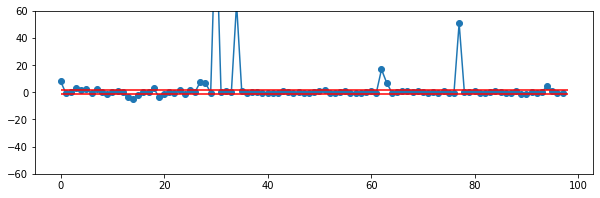

In [15]:
weights_dbg = []
wscores_dbg = []
scores_dbg = []
probes_dbg = []
for key in tqdm(["128106", "127901"]):
    utterances = zhuyin_matching(key, wlambda=3)
    utterances_start = [utt_x[1] for utt_x in sum([x[1] for x in utterances], [])]
    ans = ansdata[key]    
    print("accuracy: ", compute_metric(utterances_start, ans, tol=1.5))
    
    error=[]
    for i in range(len(ans)):
        ans_dt = datetime.strptime(ans[i], "%H:%M:%S")
        aligned_dt = datetime(1900,1,1)+timedelta(seconds=utterances_start[i])    
        #print(dt(ans_dt), dt(aligned_dt), (ans_dt-aligned_dt).total_seconds())
        error.append((ans_dt-aligned_dt).total_seconds())
    plt.figure(figsize=(10,3))
    plt.ylim(-60,60)
    plt.plot(error, marker="o")
    plt.hlines(1.5, 0, len(error), color="red")
    plt.hlines(-1.5, 0, len(error), color="red")
    plt.show()    
    break

In [16]:
def post_processing(utterances, debug=False):
    nchar = np.cumsum([len(t[0]) for t in sum([x[1] for x in utterances], [])])
    t = np.array([t[1] for t in sum([x[1] for x in utterances], [])])
    t_post = t.copy()
    X = np.vstack([np.ones(len(nchar)), nchar]).T
    dbg = []
    for idx in np.arange(len(t_post)):
        if idx == 0: continue    
        t_diff = t_post[idx] - t_post[idx-1]    
        if t_diff == 0:
            t_post[idx] = t_post[idx-1] + 0.050
            continue
        elif abs(t_diff) < 20 and t_diff > 0:
            continue        

        ## interpolate a new value
        s = max(0, idx-20)
        e = min(len(t_post), idx+20)
        cur = idx-s
        intX = X[s:e]
        intY = t[s:e]
        Qx, Rx = la.qr(intX)
        betas = la.inv(Rx).dot(Qx.T).dot(intY)    
        pred_int = intX.dot(betas)
        errors = np.abs(intY - pred_int)
        good_points = np.where(errors < 20)[0]
        left_idx = good_points[good_points < cur].max()
        right_idx = good_points[good_points > cur].min()
        m = (intY[right_idx]-intY[left_idx]) / (intX[right_idx][1]-intX[left_idx][1])
        interp_val = m * (intX[cur][1]-intX[left_idx][1]) + intY[left_idx]
        t_post[idx] = interp_val           
        
        if debug:
            dbg.append({"cur": cur, "s": s, "e": e, 
                    "intX": intX, "intY": intY,
                    "pred_int": pred_int, "good_points": good_points,
                    "left_idx":left_idx, "right_idx": right_idx,
                    "interp_val": interp_val})
    post_utterances = []
    t_pos = 0
    for turn_x in utterances:
        post_turn_x = []
        for utt_x, offset_x in turn_x[1]:
            post_turn_x.append((utt_x, t_post[t_pos]))
            t_pos += 1
        post_utterances.append((turn_x[0], post_turn_x))
        
    if debug:
        return post_utterances, dbg, {"nchar": nchar, "t": t, "t_post": t_post}
    else:
        return post_utterances

In [17]:
post_utterances, dbg, extra = post_processing(utterances, debug=True)

## Error analysis after post-processing

accuracy:  0.8061224489795918


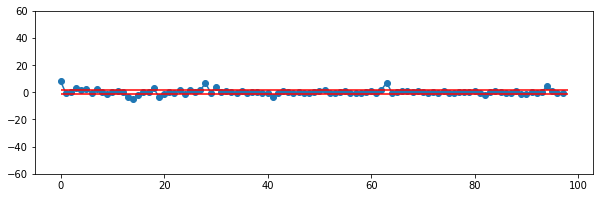

In [18]:
utterances_start = [utt_x[1] for utt_x in sum([x[1] for x in post_utterances], [])]
ans = ansdata[key]    
print("accuracy: ", compute_metric(utterances_start, ans, tol=1.5))
error=[]

for i in range(len(ans)):
    ans_dt = datetime.strptime(ans[i], "%H:%M:%S")
    aligned_dt = datetime(1900,1,1)+timedelta(seconds=utterances_start[i])    
    #print(dt(ans_dt), dt(aligned_dt), (ans_dt-aligned_dt).total_seconds())
    error.append((ans_dt-aligned_dt).total_seconds())
plt.figure(figsize=(10,3))
plt.ylim(-60,60)
plt.plot(error, marker="o")
plt.hlines(1.5, 0, len(error), color="red")
plt.hlines(-1.5, 0, len(error), color="red")
plt.show()    

In [19]:
post_utterances

[('陳委員椒華：', [('次長', 4.9), ('你有參與疫苗購買嗎', 14.4)]),
 ('薛次長瑞元：', [('疫苗的購買我略知一二', 15.5)]),
 ('陳委員椒華：', [('你沒有參與嘛', 17.2)]),
 ('薛次長瑞元：', [('對', 19.6)]),
 ('陳委員椒華：',
  [('我先提一下樂生這個案子', 23.9),
   ('我們知道這是歷史的遺憾', 28.5),
   ('所以現在就是希望能好好照顧剩下的院民', 30.9),
   ('也希望針對剩下來還住在樂生的院民', 39.5),
   ('可以以人權的考量幫他們修繕他們住習慣的地方', 50.2),
   ('不要強迫、要求他們搬遷', 63.0),
   ('不要病房式的中繼居所', 68.2)]),
 ('薛次長瑞元：', [('是', 72.1), ('這個部分我們現在正在做', 76.5)]),
 ('陳委員椒華：',
  [('次長這個部分可以做到嗎', 79.1),
   ('另外照服員的部分好像有編列 900 萬元預算', 79.14999999999999),
   ('但是現在人員好像沒有增加', 83.7),
   ('他們的待遇也沒有提升', 86.0),
   ('這個部分可以回答一下嗎', 88.0)]),
 ('薛次長瑞元：', [('跟委員報告', 94.5), ('對於不願意搬到新大樓的院民我們還是原地安置', 95.6)]),
 ('陳委員椒華：', [('尊重他們嘛', 100.5)]),
 ('薛次長瑞元：',
  [('對', 102.2), ('同時工程在進行當中', 102.25), ('就是修繕、整建、重建都在進行當中', 107.1)]),
 ('陳委員椒華：', [('希望也能夠符合他們的需求', 113.5), ('在晚年能夠住得安心', 118.7)]),
 ('薛次長瑞元：', [('包括他們關心的納骨塔我們也都排除障礙在處理當中', 119.67575757575757)]),
 ('陳委員椒華：',
  [('也能夠得到妥適的照顧', 120.1),
   ('目前只有 2 名公共照顧服務員', 129.4),
   ('次長', 130.32727272727274),
   ('這個人力可

## Debugging

In [20]:
class DebugInfo():
    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)

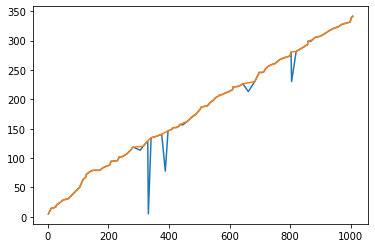

In [21]:
e = DebugInfo(**extra)
plt.plot(e.nchar, e.t)
plt.plot(e.nchar, e.t_post)

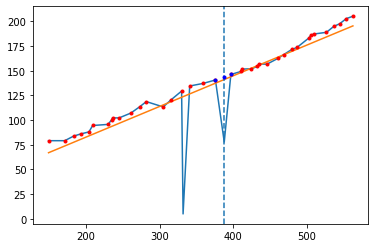

In [22]:
d = DebugInfo(**dbg[2])
plt.plot(d.intX[:,1], d.intY)
plt.plot(d.intX[:,1], d.pred_int)
plt.axvline(d.intX[d.cur,1], linestyle="dashed")
plt.plot(d.intX[d.good_points,1], d.intY[d.good_points], '.', color="red")
plt.plot(d.intX[[d.left_idx, d.right_idx], 1], d.intY[[d.left_idx, d.right_idx]], '.', color="blue")
plt.plot(d.intX[d.cur,1], d.interp_val, '.', color="blue")

## Write Textgrid

In [23]:
from praatio import textgrid
from itertools import tee

In [24]:
tg = textgrid.Textgrid()
utts = sum([x[1] for x in post_utterances], [])
entries = []
for i in range(len(utts)):
    text, start = utts[i]
    if i == len(utts)-1:
        end = start + 1
    else:
        end = utts[i+1][1]  # the start of next utt
    entries.append((start, end, text))

speaker = [(x[0], x[1][0][1]) for x in post_utterances]
speaker.append((speaker[-1][0], speaker[-1][1]+1))
it_speaker = iter(speaker)
a, b = tee(it_speaker)
next(b)
speaker_entries = [(x[1], y[1], x[0]) for x, y in zip(a, b)]

text_tier = textgrid.IntervalTier("transcript", entries)
speaker_tier = textgrid.IntervalTier("speaker", speaker_entries)
tg.addTier(text_tier)
tg.addTier(speaker_tier)
tg.save("../../data/textgrid/test.TextGrid", format="short_textgrid", includeBlankSpaces=False)

In [25]:
speaker_entries

[(4.9, 15.5, '陳委員椒華：'),
 (15.5, 17.2, '薛次長瑞元：'),
 (17.2, 19.6, '陳委員椒華：'),
 (19.6, 23.9, '薛次長瑞元：'),
 (23.9, 72.1, '陳委員椒華：'),
 (72.1, 79.1, '薛次長瑞元：'),
 (79.1, 94.5, '陳委員椒華：'),
 (94.5, 100.5, '薛次長瑞元：'),
 (100.5, 102.2, '陳委員椒華：'),
 (102.2, 113.5, '薛次長瑞元：'),
 (113.5, 119.67575757575757, '陳委員椒華：'),
 (119.67575757575757, 120.1, '薛次長瑞元：'),
 (120.1, 143.79999999999998, '陳委員椒華：'),
 (143.79999999999998, 146.2, '薛次長瑞元：'),
 (146.2, 151.6, '陳委員椒華：'),
 (151.6, 152.0, '薛次長瑞元：'),
 (152.0, 156.9, '陳委員椒華：'),
 (156.9, 159.26923076923077, '薛次長瑞元：'),
 (159.26923076923077, 197.6, '陳委員椒華：'),
 (197.6, 205.2, '薛次長瑞元：'),
 (205.2, 207.1, '陳委員椒華：'),
 (207.1, 226.4, '薛次長瑞元：'),
 (226.4, 228.06153846153848, '陳委員椒華：'),
 (228.06153846153848, 243.2, '薛次長瑞元：'),
 (243.2, 245.6, '陳委員椒華：'),
 (245.6, 245.9, '薛次長瑞元：'),
 (245.9, 251.2, '陳委員椒華：'),
 (251.2, 257.2, '薛次長瑞元：'),
 (257.2, 258.7, '陳委員椒華：'),
 (258.7, 273.7, '薛次長瑞元：'),
 (273.7, 280.61764705882354, '陳委員椒華：'),
 (280.61764705882354, 286.9, '薛次長瑞元：'),
 (286.9, 298.8, '陳委員椒華